### Klasyfikacja ręcznie rysowanych i zdigitalizowanych obrazków

Celem tego zadania jest zbudowanie i ocena modelu uczenia maszynowego do klasyfikacji prostych, ręcznie rysowanych obrazków. Zadanie polega na przetworzeniu i analizie zbioru danych zawierającego 10 różnych klas obiektów, z których każda reprezentowana jest przez trzy typy obrazów: rysowane i fotografowane, rysowane i skanowane oraz tworzone za pomocą stempli i fotografowane.

Projekt zostanie zrealizowany w czterech głównych etapach:
1.  **Eksploracja danych:** zapoznanie się ze zbiorem danych, jego strukturą, rozkładem klas i potencjalnymi problemami
2.  **Preprocessing:** przygotowanie obrazów do treningu modelu, w tym normalizacja danych
3.  **Modelowanie:** zbudowanie, wytrenowanie i porównanie trzech różnych architektur sieci konwolucyjnych (CNN)
4.  **Ewaluacja:** ocena wydajności modeli przy użyciu odpowiednich metryk i analiza wyników

##### 1. Eksploracja danych
Na tym etapie ładujemy zbiór danych i przeprowadzamy jego wstępną analizę. Naszym celem jest zrozumienie jego podstawowych cech, takich jak liczba klas, liczba obrazków w każdej klasie oraz wizualna prezentacja próbek. Pozwoli nam to zidentyfikować potencjalne problemy, takie jak niezbalansowanie klas, które mogłyby wpłynąć na proces trenowania modelu.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import random
import collections
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# ładowanie datasetu
full_ds = torchvision.datasets.ImageFolder(root="data")
class_names = full_ds.classes
num_classes = len(class_names)

print(f"Liczba obrazków: {len(full_ds)}")
print("Liczba klas:", num_classes)

Liczba obrazków: 431
Liczba klas: 10


**Podział na zbiór treningowy i testowy**

Kluczowym krokiem jest podział danych na zbiór treningowy i testowy. Zbiór testowy zostanie całkowicie wyłączony z dalszej analizy i procesu trenowania. Użyjemy podziału 80/20, gdzie 80% danych posłuży do trenowania i walidacji, a pozostałe 20% do testowania.

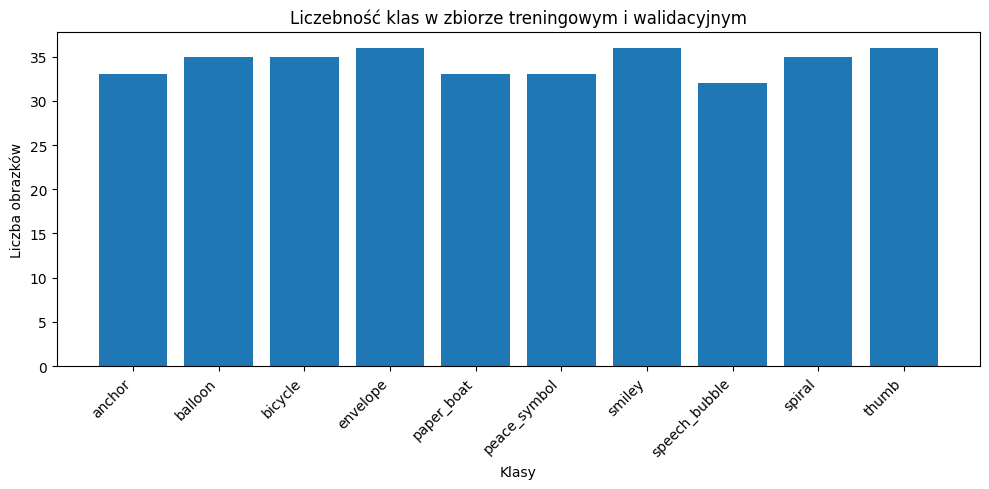

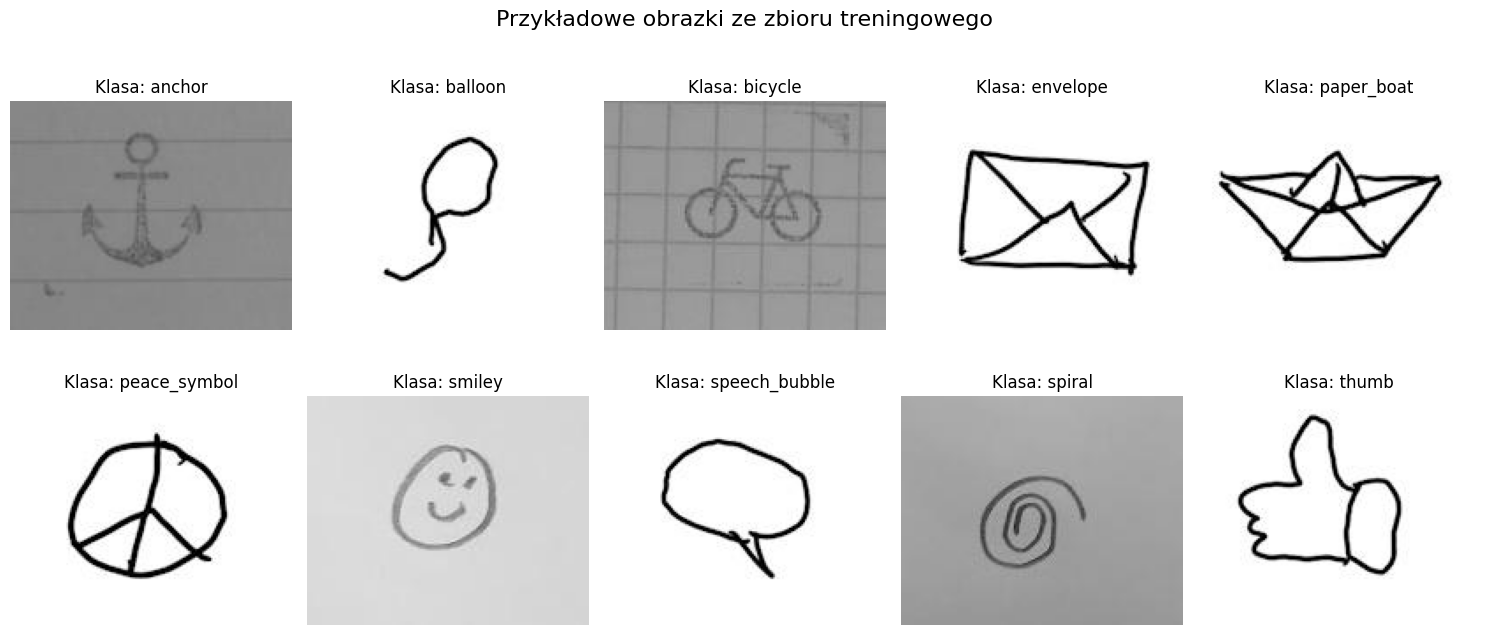

In [3]:
# dzielenie datasetu na train i test
train_val_size = int(0.8 * len(full_ds))
test_size = len(full_ds) - train_val_size
train_val_ds, test_ds = torch.utils.data.random_split(full_ds, [train_val_size, test_size])
train_val_targets = np.array(full_ds.targets)[train_val_ds.indices]

# badanie zrównoważenia klas w zbiorze treningowym
class_counter = collections.Counter(train_val_targets)

plt.figure(figsize=(10, 5))
plt.bar(class_counter.keys(), class_counter.values())
plt.xticks(range(num_classes), class_names, rotation=45, ha="right")
plt.xlabel("Klasy")
plt.ylabel("Liczba obrazków")
plt.title("Liczebność klas w zbiorze treningowym i walidacyjnym")
plt.tight_layout()
plt.savefig("figures/liczebnosc-klas.png")
plt.show()

# wizualizacja zbioru treningowego
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
fig.suptitle("Przykładowe obrazki ze zbioru treningowego", fontsize=16)
for i, class_name in enumerate(class_names):
    class_idx = full_ds.class_to_idx[class_name]
    target_ixs = np.where(train_val_targets == class_idx)[0]
    
    ix = random.choice(target_ixs)
    img, label = train_val_ds[ix]
    
    ax = axes.flat[i]
    ax.imshow(img)
    ax.set_title(f"Klasa: {class_name}")
    ax.axis('off')

# zapisywanie wizualizacji
plt.tight_layout()
plt.savefig("figures/ds-wizualizacja.png")

**Wnioski z przeprowadzonej eksploracji danych** 

Jak widać na powyższym wykresie, zbiór treningowy jest stosunkowo dobrze zbalansowany. Liczba obrazków w poszczególnych klasach jest do siebie zbliżona, co jest korzystne dla procesu uczenia i zmniejsza ryzyko, że model będzie faworyzował klasy liczniejsze.

#### 2. Preprocessing 

W tym etapie surowe obrazki (w formacie PIL) zostaną przekształcone do postaci tensorów. Ponadto, przeprowadzimy normalizację, która polega na przeskalowaniu wartości pikseli tak, aby miały średnią równą 0 i odchylenie standardowe równe 1. Obliczymy średnią i odchylenie standardowe na podstawie zbioru treningowego, aby uniknąć wycieku informacji ze zbioru testowego.

In [4]:
train_val_ds_for_calc = torchvision.datasets.ImageFolder(root="data", transform=torchvision.transforms.ToTensor())
train_val_ds_for_calc = torch.utils.data.Subset(train_val_ds_for_calc, train_val_ds.indices)

calc_loader = torch.utils.data.DataLoader(train_val_ds_for_calc, batch_size=64)

mean = 0
std = 0
n_samples = 0

for images_batch, labels_batch in calc_loader:
    images_flat = images_batch.view(images_batch.size(0), images_batch.size(1), -1)

    mean += images_flat.mean(2).sum(0)
    std += images_flat.std(2).sum(0)
    n_samples += images_batch.size(0)

mean /= n_samples
std /= n_samples

print(f"Obliczone wartości dla zbioru treningowego:")
print(f"Średnia: {mean}")
print(f"Odchylenie standardowe: {std}")

Obliczone wartości dla zbioru treningowego:
Średnia: tensor([0.7567, 0.7567, 0.7567])
Odchylenie standardowe: tensor([0.1060, 0.1060, 0.1060])


Zdefiniujemy dwie różne ścieżki transformacji obrazów:

1.  **Transformacja standardowa (`transform_norm`):** Używana dla naszych własnych, prostych modeli CNN. Obejmuje konwersję do tensora i normalizację z wykorzystaniem obliczonych wcześniej statystyk.

2.  **Transformacja dla modelu pretrained (`transform_pretrained`):** Używana dla modelu ResNet18. Oprócz konwersji do tensora, obrazy są skalowane do rozmiaru 224x224, a normalizacja odbywa się z użyciem standardowych wartości dla zbioru ImageNet, na którym model był pierwotnie trenowany.
```

In [5]:
# normalizacja zbioru dla modelu 1 i 2
transform_norm = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(mean=mean, std=std)])

# normalizacja zbioru dla modelu 3 (ResNet18)
transform_pretrained = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# tworzenie zbiorów dla modeli 1 i 2
full_ds_norm = torchvision.datasets.ImageFolder(root="data", transform=transform_norm)
train_val_ds_norm = torch.utils.data.Subset(full_ds_norm, train_val_ds.indices)
test_ds_norm = torch.utils.data.Subset(full_ds_norm, test_ds.indices)

# tworzenie zbiorów dla modelu 3 (ResNet18)
full_ds_pretrained = torchvision.datasets.ImageFolder(root="data", transform=transform_pretrained)
train_val_ds_pretrained = torch.utils.data.Subset(full_ds_pretrained, train_val_ds.indices)
test_ds_pretrained = torch.utils.data.Subset(full_ds_pretrained, test_ds.indices)

#### 3. Modele

W tej części zdefiniujemy, wytrenujemy i porównamy trzy różne architektury sieci konwolucyjnych, ponieważ są one standardem w problemach związanych z przetwarzaniem i klasyfikacją obrazów. Zaczniemy od prostego modelu CNN, następnie wprowadzimy ulepszenia w postaci batch normalization i dropoutu, a na końcu wykorzystamy architekturę ResNet18. Jako funkcję straty wybieramy `CrossEntropyLoss`, a jako optymalizator znany i lubiany - optymalizator `Adam`.

- **Model 1 (CNN1)**: Prosta sieć z trzema warstwami konwolucyjnymi, każda z nich jest połączona z warstwą max-pooling, a następnie z warstwą w pełni połączoną

In [6]:
# model 1
class CNN1(torch.nn.Module):

    def __init__(self, input_size, num_classes):
        super(CNN1, self).__init__()

        self.conv_block1 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=input_size, out_channels=16, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        

        self.conv_block3 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=32, out_channels=40, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = torch.nn.Linear(40 * 16 * 20, num_classes)

    def forward(self, x):

        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)

        return x
    
model1 = CNN1(input_size=3, num_classes=len(class_names))

# optimizer hyperparameters
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)

* **Model 2 (CNN2):** To rozbudowana wersja pierwszego. Do każdego bloku konwolucyjnego dodajemy warstwę `BatchNorm2d`, która stabilizuje i przyspiesza proces uczenia. Przed warstwą klasyfikującą dodajemy również warstwę `Dropout` z prawdopodobieństwem 0.5

In [7]:
# model 2
class CNN2(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN2, self).__init__()

        self.conv_block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=input_size, out_channels=16, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(48),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(48 * 16 * 20, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.classifier(x)
        return x

model2 = CNN2(input_size=3, num_classes=len(class_names))

# optimizer hyperparameters
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

* **Model 3:** Trzecie podejście to transfer learning. Wykorzystujemy wytrenowany wcześniej model ResNet18. "Zamrażamy" wagi wszystkich warstw konwolucyjnych, aby zachować wiedzę zdobytą na ImageNet, a następnie zastępujemy oryginalną warstwę klasyfikującą nową, dostosowaną do naszego problemu (10 klas).

In [8]:
# model 3
model3 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

for param in model3.parameters():
    param.requires_grad = False

num_ftrs = model3.fc.in_features
print(num_ftrs)
model3.fc = torch.nn.Linear(num_ftrs, num_classes)

optimizer3 = torch.optim.Adam(model3.fc.parameters(), lr=0.001)

512


In [9]:
epochs = 30
criterion = torch.nn.CrossEntropyLoss()

val_size = int(0.2 * len(train_val_ds))
train_size = len(train_val_ds) - val_size

# tworzenie loaderów dla modeli 1 i 2
train_ds_norm, val_ds_norm = torch.utils.data.random_split(train_val_ds_norm, [train_size, val_size])

train_loader_norm = torch.utils.data.DataLoader(train_ds_norm, batch_size=64, shuffle=True)
val_loader_norm = torch.utils.data.DataLoader(val_ds_norm, batch_size=64, shuffle=False)
test_loader_norm = torch.utils.data.DataLoader(test_ds_norm, batch_size=64, shuffle=False)

# te same indeksy dla modelu 3
train_idx, val_idx = train_ds_norm.indices, val_ds_norm.indices

# tworzenie loaderów dla modelu 3 (ResNet18)
train_ds_pretrained = torch.utils.data.Subset(train_val_ds_pretrained, train_idx)
val_ds_pretrained = torch.utils.data.Subset(train_val_ds_pretrained, val_idx)

train_loader_pretrained = torch.utils.data.DataLoader(train_ds_pretrained, batch_size=64, shuffle=True)
val_loader_pretrained = torch.utils.data.DataLoader(val_ds_pretrained, batch_size=64, shuffle=False)
test_loader_pretrained = torch.utils.data.DataLoader(test_ds_pretrained, batch_size=64, shuffle=False)


print(f"Wielkość zbioru treningowego: {len(train_ds_norm)}")
print(f"Wielkość zbioru walidacyjnego: {len(val_ds_norm)}")
print(f"Wielkość zbioru testowego: {len(test_ds_norm)}")


Wielkość zbioru treningowego: 276
Wielkość zbioru walidacyjnego: 68
Wielkość zbioru testowego: 87


100%|██████████| 2/2 [00:00<00:00, 16.99it/s]


Epoch [1/30], Train Loss: 2.2049, Val Loss: 1.8610


100%|██████████| 2/2 [00:00<00:00, 14.33it/s]


Epoch [2/30], Train Loss: 1.5354, Val Loss: 1.1798


100%|██████████| 2/2 [00:00<00:00, 17.55it/s]


Epoch [3/30], Train Loss: 1.1257, Val Loss: 0.9463


100%|██████████| 2/2 [00:00<00:00, 17.32it/s]


Epoch [4/30], Train Loss: 1.0218, Val Loss: 0.9012


100%|██████████| 2/2 [00:00<00:00, 17.57it/s]


Epoch [5/30], Train Loss: 0.8852, Val Loss: 0.9635


100%|██████████| 2/2 [00:00<00:00, 12.33it/s]


Epoch [6/30], Train Loss: 0.7231, Val Loss: 0.7528


100%|██████████| 2/2 [00:00<00:00, 16.53it/s]


Epoch [7/30], Train Loss: 0.5124, Val Loss: 0.5230


100%|██████████| 2/2 [00:00<00:00, 17.05it/s]


Epoch [8/30], Train Loss: 0.3370, Val Loss: 0.7988


100%|██████████| 2/2 [00:00<00:00, 17.69it/s]


Epoch [9/30], Train Loss: 0.3384, Val Loss: 0.6437


100%|██████████| 2/2 [00:00<00:00, 12.08it/s]


Epoch [10/30], Train Loss: 0.2434, Val Loss: 0.4929


100%|██████████| 2/2 [00:00<00:00, 17.44it/s]


Epoch [11/30], Train Loss: 0.1783, Val Loss: 0.5908


100%|██████████| 2/2 [00:00<00:00, 17.63it/s]


Epoch [12/30], Train Loss: 0.1415, Val Loss: 0.7208


100%|██████████| 2/2 [00:00<00:00, 16.72it/s]


Epoch [13/30], Train Loss: 0.1131, Val Loss: 0.7687


100%|██████████| 2/2 [00:00<00:00, 16.62it/s]


Epoch [14/30], Train Loss: 0.0606, Val Loss: 0.5642


100%|██████████| 2/2 [00:00<00:00, 17.46it/s]


Epoch [15/30], Train Loss: 0.0483, Val Loss: 0.8655


100%|██████████| 2/2 [00:00<00:00, 17.07it/s]


Epoch [16/30], Train Loss: 0.0652, Val Loss: 0.6731


100%|██████████| 2/2 [00:00<00:00, 13.72it/s]


Epoch [17/30], Train Loss: 0.0346, Val Loss: 0.3939


100%|██████████| 2/2 [00:00<00:00, 17.48it/s]


Epoch [18/30], Train Loss: 0.0508, Val Loss: 0.4627


100%|██████████| 2/2 [00:00<00:00, 17.27it/s]


Epoch [19/30], Train Loss: 0.0249, Val Loss: 0.4397


100%|██████████| 2/2 [00:00<00:00, 17.35it/s]


Epoch [20/30], Train Loss: 0.0437, Val Loss: 0.5757


100%|██████████| 2/2 [00:00<00:00,  9.96it/s]


Epoch [21/30], Train Loss: 0.0410, Val Loss: 0.4927


100%|██████████| 2/2 [00:00<00:00, 17.52it/s]


Epoch [22/30], Train Loss: 0.0816, Val Loss: 0.5418


100%|██████████| 2/2 [00:00<00:00, 14.42it/s]


Epoch [23/30], Train Loss: 0.0520, Val Loss: 0.6871


100%|██████████| 2/2 [00:00<00:00, 17.38it/s]


Epoch [24/30], Train Loss: 0.0316, Val Loss: 0.6001


100%|██████████| 2/2 [00:00<00:00, 11.43it/s]


Epoch [25/30], Train Loss: 0.0698, Val Loss: 0.6024


100%|██████████| 2/2 [00:00<00:00, 17.59it/s]


Epoch [26/30], Train Loss: 0.1123, Val Loss: 0.8439


100%|██████████| 2/2 [00:00<00:00, 17.51it/s]


Epoch [27/30], Train Loss: 0.0917, Val Loss: 0.8260


100%|██████████| 2/2 [00:00<00:00, 17.18it/s]


Epoch [28/30], Train Loss: 0.0756, Val Loss: 0.6966


100%|██████████| 2/2 [00:00<00:00, 12.72it/s]


Epoch [29/30], Train Loss: 0.0261, Val Loss: 0.6687


100%|██████████| 2/2 [00:00<00:00, 17.59it/s]

Epoch [30/30], Train Loss: 0.0258, Val Loss: 0.6049


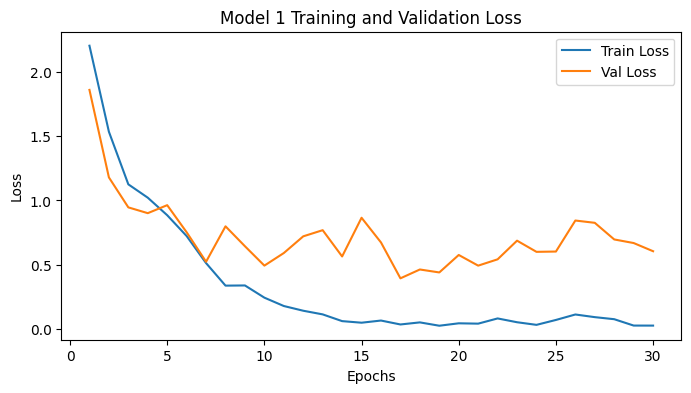

In [10]:
# training loop model 1
train_losses_1 = []
val_losses_1 = []

for epoch in range(epochs):
    model1.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader_norm):
        outputs = model1(images)
        loss = criterion(outputs, labels)

        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        train_loss += loss.item()
    train_losses_1.append(train_loss / len(train_loader_norm))
    
    model1.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader_norm):
            outputs = model1(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_losses_1.append(val_loss / len(val_loader_norm))



    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader_norm):.4f}, Val Loss: {val_loss/len(val_loader_norm):.4f}")

plt.figure(figsize=(8, 4))
plt.title("Model 1 Training and Validation Loss")
plt.plot(range(1, epochs+1), train_losses_1, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses_1, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("figures/model1-losses.png")
plt.show()

100%|██████████| 2/2 [00:00<00:00, 14.93it/s]


Epoch [1/30], Train Loss: 3.4525, Val Loss: 2.2806


100%|██████████| 2/2 [00:00<00:00, 16.19it/s]


Epoch [2/30], Train Loss: 2.3645, Val Loss: 1.4915


100%|██████████| 2/2 [00:00<00:00, 15.64it/s]


Epoch [3/30], Train Loss: 1.1607, Val Loss: 1.0806


100%|██████████| 2/2 [00:00<00:00, 13.72it/s]


Epoch [4/30], Train Loss: 0.8099, Val Loss: 1.1290


100%|██████████| 2/2 [00:00<00:00, 10.13it/s]


Epoch [5/30], Train Loss: 0.6842, Val Loss: 1.0435


100%|██████████| 2/2 [00:00<00:00, 14.02it/s]


Epoch [6/30], Train Loss: 0.5727, Val Loss: 0.9495


100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


Epoch [7/30], Train Loss: 0.4069, Val Loss: 0.8313


100%|██████████| 2/2 [00:00<00:00, 14.32it/s]


Epoch [8/30], Train Loss: 0.3660, Val Loss: 0.8373


100%|██████████| 2/2 [00:00<00:00, 16.31it/s]


Epoch [9/30], Train Loss: 0.2595, Val Loss: 0.7183


100%|██████████| 2/2 [00:00<00:00, 15.18it/s]


Epoch [10/30], Train Loss: 0.2100, Val Loss: 0.6580


100%|██████████| 2/2 [00:00<00:00, 16.13it/s]


Epoch [11/30], Train Loss: 0.1803, Val Loss: 0.6653


100%|██████████| 2/2 [00:00<00:00, 15.93it/s]


Epoch [12/30], Train Loss: 0.1312, Val Loss: 0.8110


100%|██████████| 2/2 [00:00<00:00, 12.36it/s]


Epoch [13/30], Train Loss: 0.1512, Val Loss: 0.6142


100%|██████████| 2/2 [00:00<00:00, 13.63it/s]


Epoch [14/30], Train Loss: 0.1381, Val Loss: 0.5772


100%|██████████| 2/2 [00:00<00:00, 16.51it/s]


Epoch [15/30], Train Loss: 0.0933, Val Loss: 0.5456


100%|██████████| 2/2 [00:00<00:00, 16.05it/s]


Epoch [16/30], Train Loss: 0.0714, Val Loss: 0.7535


100%|██████████| 2/2 [00:00<00:00, 16.21it/s]


Epoch [17/30], Train Loss: 0.0638, Val Loss: 0.6246


100%|██████████| 2/2 [00:00<00:00, 15.85it/s]


Epoch [18/30], Train Loss: 0.0529, Val Loss: 0.5477


100%|██████████| 2/2 [00:00<00:00, 15.92it/s]


Epoch [19/30], Train Loss: 0.0476, Val Loss: 0.5587


100%|██████████| 2/2 [00:00<00:00, 15.51it/s]


Epoch [20/30], Train Loss: 0.0413, Val Loss: 0.4722


100%|██████████| 2/2 [00:00<00:00, 16.24it/s]


Epoch [21/30], Train Loss: 0.0341, Val Loss: 0.4874


100%|██████████| 2/2 [00:00<00:00, 10.32it/s]


Epoch [22/30], Train Loss: 0.0422, Val Loss: 0.5676


100%|██████████| 2/2 [00:00<00:00, 12.02it/s]


Epoch [23/30], Train Loss: 0.0334, Val Loss: 0.5251


100%|██████████| 2/2 [00:00<00:00, 12.94it/s]


Epoch [24/30], Train Loss: 0.0287, Val Loss: 0.4875


100%|██████████| 2/2 [00:00<00:00,  6.58it/s]


Epoch [25/30], Train Loss: 0.0239, Val Loss: 0.4610


100%|██████████| 2/2 [00:00<00:00, 12.95it/s]


Epoch [26/30], Train Loss: 0.0176, Val Loss: 0.5029


100%|██████████| 2/2 [00:00<00:00, 15.98it/s]


Epoch [27/30], Train Loss: 0.0237, Val Loss: 0.4831


100%|██████████| 2/2 [00:00<00:00, 15.76it/s]


Epoch [28/30], Train Loss: 0.0212, Val Loss: 0.5538


100%|██████████| 2/2 [00:00<00:00, 13.68it/s]


Epoch [29/30], Train Loss: 0.0199, Val Loss: 0.5370


100%|██████████| 2/2 [00:00<00:00, 12.80it/s]


Epoch [30/30], Train Loss: 0.0129, Val Loss: 0.5362


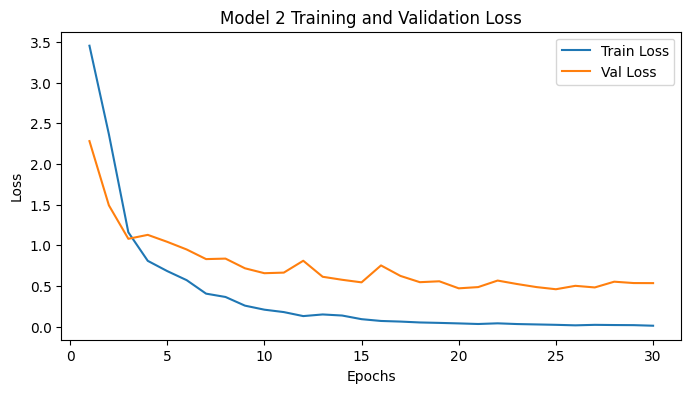

In [11]:
# training loop model 2
train_losses_2 = []
val_losses_2 = []

for epoch in range(epochs):
    model2.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader_norm):
        outputs = model2(images)
        loss = criterion(outputs, labels)

        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        train_loss += loss.item()
    train_losses_2.append(train_loss / len(train_loader_norm))
    
    model2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader_norm):
            outputs = model2(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_losses_2.append(val_loss / len(val_loader_norm))

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader_norm):.4f}, Val Loss: {val_loss/len(val_loader_norm):.4f}")

plt.figure(figsize=(8, 4))
plt.title("Model 2 Training and Validation Loss")
plt.plot(range(1, epochs+1), train_losses_2, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses_2, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("figures/model2-losses.png")
plt.show()

100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Epoch [1/30], Train Loss: 2.3293, Val Loss: 2.1729


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Epoch [2/30], Train Loss: 1.9426, Val Loss: 1.9776


100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Epoch [3/30], Train Loss: 1.6478, Val Loss: 1.8101


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Epoch [4/30], Train Loss: 1.3589, Val Loss: 1.5980


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Epoch [5/30], Train Loss: 1.1578, Val Loss: 1.3656


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Epoch [6/30], Train Loss: 1.0094, Val Loss: 1.2161


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Epoch [7/30], Train Loss: 0.8588, Val Loss: 1.1835


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Epoch [8/30], Train Loss: 0.7663, Val Loss: 1.1350


100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Epoch [9/30], Train Loss: 0.6812, Val Loss: 0.9548


100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Epoch [10/30], Train Loss: 0.6147, Val Loss: 0.8108


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Epoch [11/30], Train Loss: 0.5422, Val Loss: 0.7314


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


Epoch [12/30], Train Loss: 0.4675, Val Loss: 0.7014


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Epoch [13/30], Train Loss: 0.4509, Val Loss: 0.6486


100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


Epoch [14/30], Train Loss: 0.4250, Val Loss: 0.5971


100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


Epoch [15/30], Train Loss: 0.3968, Val Loss: 0.5410


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Epoch [16/30], Train Loss: 0.3739, Val Loss: 0.5278


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Epoch [17/30], Train Loss: 0.3651, Val Loss: 0.4997


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Epoch [18/30], Train Loss: 0.3243, Val Loss: 0.4787


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Epoch [19/30], Train Loss: 0.3203, Val Loss: 0.4468


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Epoch [20/30], Train Loss: 0.3070, Val Loss: 0.4320


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Epoch [21/30], Train Loss: 0.2698, Val Loss: 0.4043


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch [22/30], Train Loss: 0.2681, Val Loss: 0.3914


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Epoch [23/30], Train Loss: 0.2491, Val Loss: 0.3984


100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


Epoch [24/30], Train Loss: 0.2356, Val Loss: 0.3708


100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


Epoch [25/30], Train Loss: 0.2386, Val Loss: 0.3527


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Epoch [26/30], Train Loss: 0.2217, Val Loss: 0.3355


100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Epoch [27/30], Train Loss: 0.1902, Val Loss: 0.3260


100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


Epoch [28/30], Train Loss: 0.2007, Val Loss: 0.3269


100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


Epoch [29/30], Train Loss: 0.1971, Val Loss: 0.3353


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

Epoch [30/30], Train Loss: 0.1950, Val Loss: 0.3212


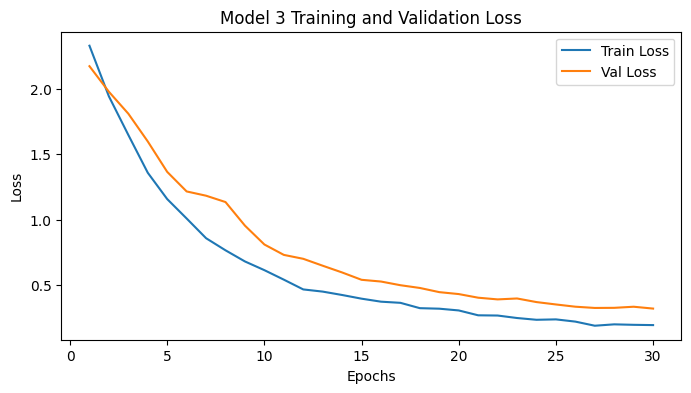

In [12]:
# training loop model 3
train_losses_3 = []
val_losses_3 = []

for epoch in range(epochs):
    model3.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader_pretrained):
        outputs = model3(images)
        loss = criterion(outputs, labels)

        optimizer3.zero_grad()
        loss.backward()
        optimizer3.step()
        train_loss += loss.item()
    train_losses_3.append(train_loss / len(train_loader_pretrained))
    
    model3.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader_pretrained):
            outputs = model3(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_losses_3.append(val_loss / len(val_loader_pretrained))

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader_pretrained):.4f}, Val Loss: {val_loss/len(val_loader_pretrained):.4f}")

plt.figure(figsize=(8, 4))
plt.title("Model 3 Training and Validation Loss")
plt.plot(range(1, epochs+1), train_losses_3, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses_3, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("figures/model3-losses.png")
plt.show()

#### 4. Ewaluacja modeli

Na tym etapie oceniamy ostateczną skuteczność modeli na zbiorze testowym. Celem jest weryfikacja, jak dobrze modele generalizują wiedzę na nowe dane.

Wybrane metryki:

*   **Raport klasyfikacji:** zamiast samej dokładności (Accuracy), analizujemy też inne metryki:
    *   **Precision**
    *   **Recall**
    *   **F1-Score**

*   **Confusion matrix:** pokazuje, które klasy są ze sobą najczęściej mylone

In [13]:
def evaluate_model(model, dataloader, model_name):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
            
    print(f"--- Ewaluacja dla: {model_name} ---")
    
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nRaport klasyfikacji:")
    print(report)
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Przewidziana etykieta')
    plt.ylabel('Prawdziwa etykieta')
    plt.title(f'Confusion matrix dla {model_name}')
    plt.savefig(f"figures/{model_name.replace(" ", "_").lower()}.png")
    plt.show()

--- Ewaluacja dla: Model 1 (CNN1) ---

Raport klasyfikacji:
               precision    recall  f1-score   support

       anchor       1.00      0.82      0.90        11
      balloon       1.00      1.00      1.00         8
      bicycle       0.90      1.00      0.95         9
     envelope       1.00      0.75      0.86         8
   paper_boat       0.82      1.00      0.90         9
 peace_symbol       0.90      0.90      0.90        10
       smiley       0.71      0.71      0.71         7
speech_bubble       1.00      0.89      0.94         9
       spiral       0.50      0.62      0.56         8
        thumb       0.88      0.88      0.88         8

     accuracy                           0.86        87
    macro avg       0.87      0.86      0.86        87
 weighted avg       0.88      0.86      0.87        87



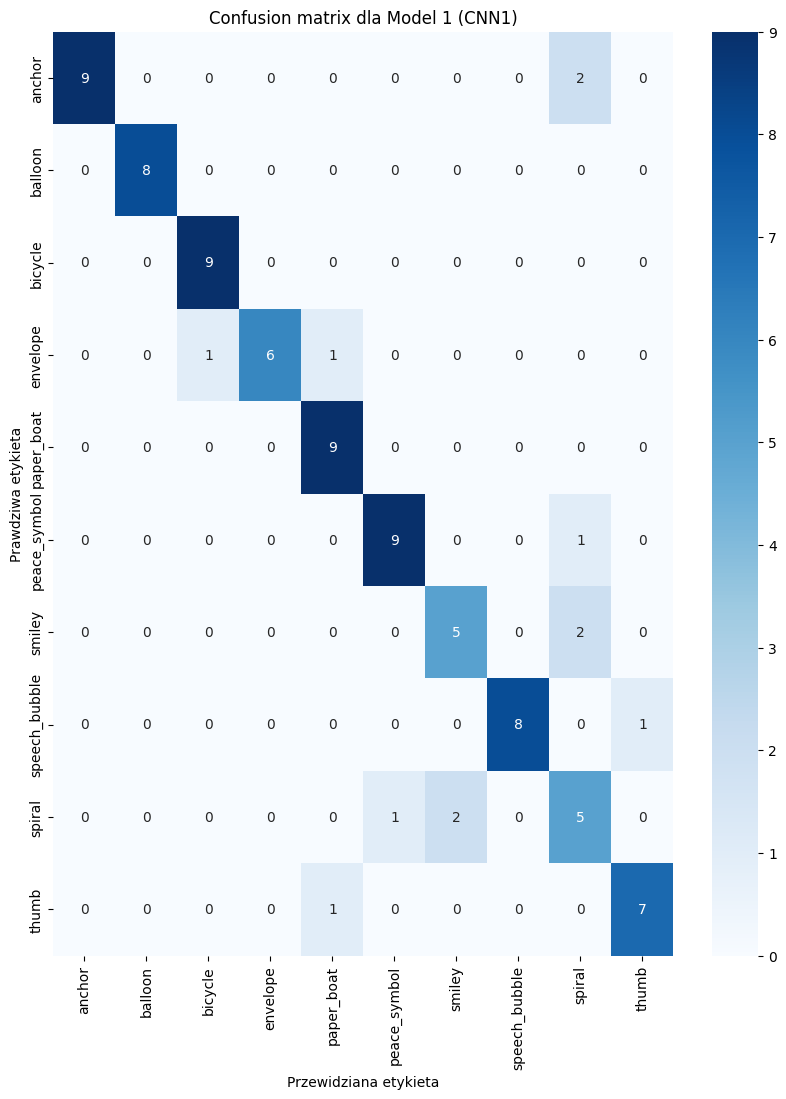

--- Ewaluacja dla: Model 2 (CNN2) ---

Raport klasyfikacji:
               precision    recall  f1-score   support

       anchor       1.00      0.91      0.95        11
      balloon       1.00      1.00      1.00         8
      bicycle       1.00      0.78      0.88         9
     envelope       0.88      0.88      0.88         8
   paper_boat       0.90      1.00      0.95         9
 peace_symbol       1.00      0.70      0.82        10
       smiley       0.83      0.71      0.77         7
speech_bubble       1.00      1.00      1.00         9
       spiral       0.50      0.88      0.64         8
        thumb       1.00      1.00      1.00         8

     accuracy                           0.89        87
    macro avg       0.91      0.89      0.89        87
 weighted avg       0.92      0.89      0.89        87



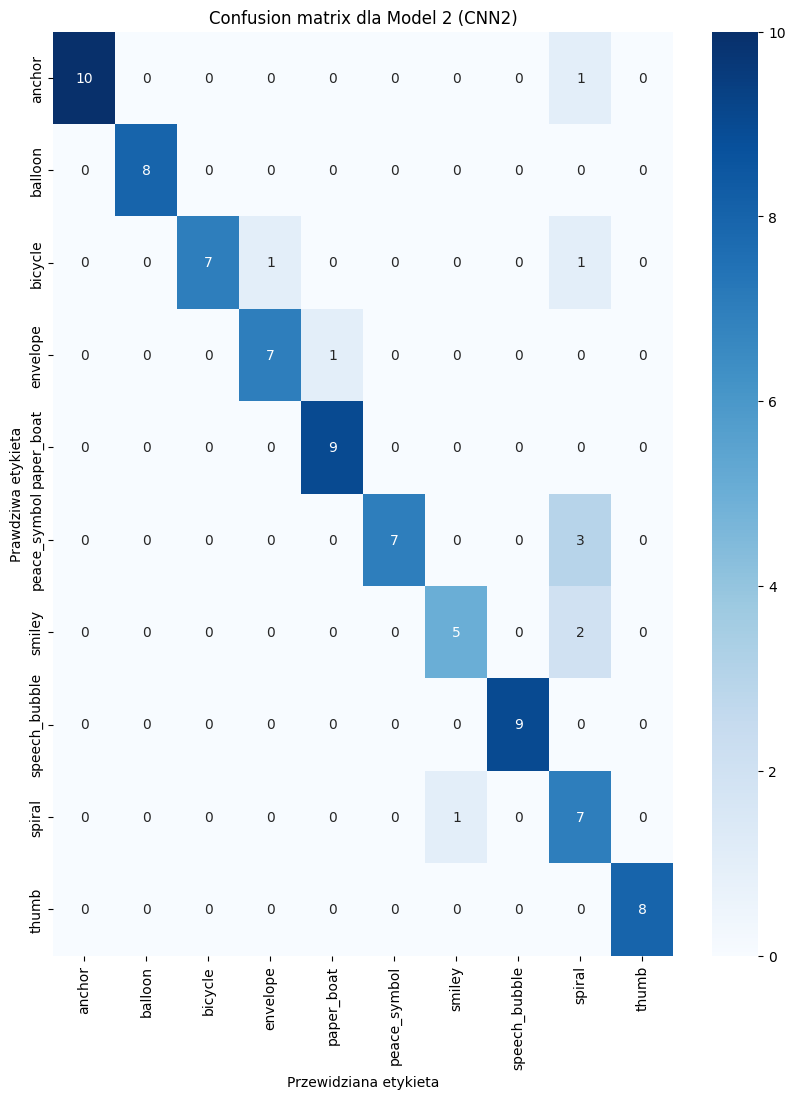

--- Ewaluacja dla: Model 3 (ResNet18) ---

Raport klasyfikacji:
               precision    recall  f1-score   support

       anchor       1.00      1.00      1.00        11
      balloon       0.88      0.88      0.88         8
      bicycle       1.00      1.00      1.00         9
     envelope       1.00      1.00      1.00         8
   paper_boat       0.90      1.00      0.95         9
 peace_symbol       1.00      1.00      1.00        10
       smiley       1.00      1.00      1.00         7
speech_bubble       0.89      0.89      0.89         9
       spiral       1.00      1.00      1.00         8
        thumb       1.00      0.88      0.93         8

     accuracy                           0.97        87
    macro avg       0.97      0.96      0.96        87
 weighted avg       0.97      0.97      0.97        87



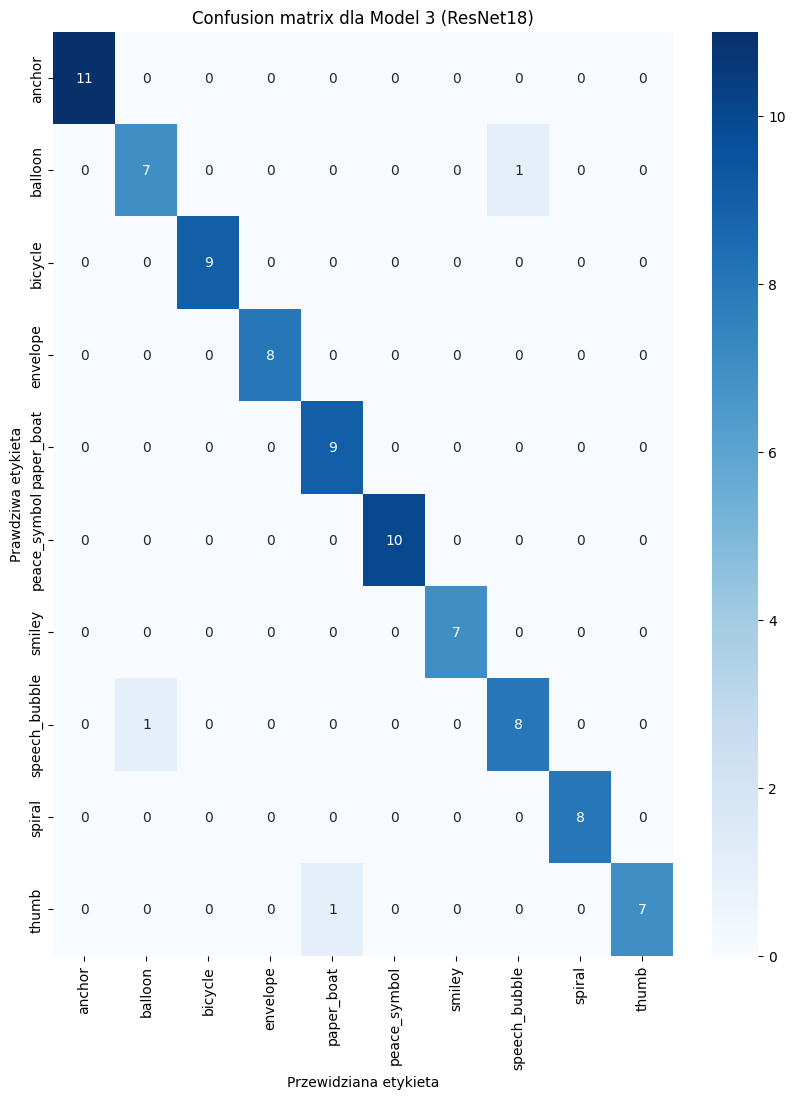

In [14]:
# ewaluacja modeli
evaluate_model(model1, test_loader_norm, "Model 1 (CNN1)")
evaluate_model(model2, test_loader_norm, "Model 2 (CNN2)")
evaluate_model(model3, test_loader_pretrained, "Model 3 (ResNet18)")

**Wyniki pokazały wyraźną progresję:**
* Prosty model CNN1 stanowił solidną bazę, ale miał trudności z niektórymi klasami
* Ulepszony CNN2 z batch normalization i dropoutem wykazał znaczącą poprawę
* Model oparty o transfer learning (ResNet18) okazał się zdecydowanie najskuteczniejszy, osiągając niemal bezbłędne wyniki i deklasując modele trenowane od zera

**Analiza Błędów**
* **Błędy modeli:** Słabością prostszych architektur było mylenie klas o podobnych cechach wizualnych (np. smiley, speech_bubble, spiral), co było widoczne na ich macierzach pomyłek. Model ResNet18 niemal całkowicie wyeliminował te problemy
* **Wyciek danych:** Początkowo prawdopodobnie niepoprawne podzielenie i użycie datasetu, co mogło doprowadzić do wycieku danych

**Miejsca do poprawy**

Chociaż osiągnięto bardzo dobre wyniki, istnieją dalsze możliwości progresji:
* **Augmentacja danych:** Zastosowanie technik takich jak losowe obroty czy zmiany jasności mogłyby jeszcze bardziej zwiększyć odporność modelu, nawet tego najlepszego
* **Eksperymenty z hiperparametrami:** Można by przetestować inne optymalizatory, wartości współczynnika uczenia czy większą liczbę epok treningowych

### Augmentacja danych
Ponownie wytrenujemy **Model 2 (CNN2)** na zbiorze z augmentacją. Wybraliśmy ten model, ponieważ jego wyniki nie były idealne, co stwarza przestrzeń do widocznej poprawy


In [15]:
# transformacja z augmentacją dla zbioru treningowego i walidacyjnego
transform_with_aug = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

# zbiór testowy pozostawiamy bez augmentacji
transform_norm = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

In [16]:
full_ds_with_aug = torchvision.datasets.ImageFolder(root="data", transform=transform_with_aug)
train_val_ds_with_aug = torch.utils.data.Subset(full_ds_with_aug, train_val_ds.indices)

# te same indeksy co wcześniej
train_idx = train_ds_norm.indices

# zbiór treningowy z augmentacją, walidacyjny i testowy pozostają takie same
train_ds_aug = torch.utils.data.Subset(train_val_ds_with_aug, train_idx)

# tworzymy nowy loader
train_loader_aug = torch.utils.data.DataLoader(train_ds_aug, batch_size=64, shuffle=True, num_workers=0)

print(f"Nowy zbiór treningowy (z augmentacją): {len(train_ds_aug)} obrazków")

Nowy zbiór treningowy (z augmentacją): 276 obrazków


100%|██████████| 2/2 [00:00<00:00, 12.73it/s]


Epoch [1/30], Train Loss: 4.7679, Val Loss: 2.4611


100%|██████████| 2/2 [00:00<00:00, 12.09it/s]


Epoch [2/30], Train Loss: 3.8625, Val Loss: 2.1681


100%|██████████| 2/2 [00:00<00:00, 13.07it/s]


Epoch [3/30], Train Loss: 2.4275, Val Loss: 1.5499


100%|██████████| 2/2 [00:00<00:00, 16.76it/s]


Epoch [4/30], Train Loss: 2.2229, Val Loss: 1.5279


100%|██████████| 2/2 [00:00<00:00, 16.32it/s]


Epoch [5/30], Train Loss: 1.9703, Val Loss: 1.3452


100%|██████████| 2/2 [00:00<00:00, 16.54it/s]


Epoch [6/30], Train Loss: 1.4227, Val Loss: 1.3388


100%|██████████| 2/2 [00:00<00:00, 13.96it/s]


Epoch [7/30], Train Loss: 1.4654, Val Loss: 0.9134


100%|██████████| 2/2 [00:00<00:00, 15.68it/s]


Epoch [8/30], Train Loss: 1.1704, Val Loss: 1.0067


100%|██████████| 2/2 [00:00<00:00, 12.22it/s]


Epoch [9/30], Train Loss: 1.0873, Val Loss: 0.9101


100%|██████████| 2/2 [00:00<00:00, 16.72it/s]


Epoch [10/30], Train Loss: 0.9353, Val Loss: 0.8501


100%|██████████| 2/2 [00:00<00:00, 16.24it/s]


Epoch [11/30], Train Loss: 0.9639, Val Loss: 1.0159


100%|██████████| 2/2 [00:00<00:00, 14.69it/s]


Epoch [12/30], Train Loss: 0.9383, Val Loss: 0.9457


100%|██████████| 2/2 [00:00<00:00, 16.27it/s]


Epoch [13/30], Train Loss: 0.8117, Val Loss: 0.9449


100%|██████████| 2/2 [00:00<00:00, 16.63it/s]


Epoch [14/30], Train Loss: 0.7199, Val Loss: 0.7403


100%|██████████| 2/2 [00:00<00:00, 16.71it/s]


Epoch [15/30], Train Loss: 0.6959, Val Loss: 0.9429


100%|██████████| 2/2 [00:00<00:00, 11.43it/s]


Epoch [16/30], Train Loss: 0.7139, Val Loss: 0.8495


100%|██████████| 2/2 [00:00<00:00, 11.20it/s]


Epoch [17/30], Train Loss: 0.6844, Val Loss: 0.7202


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Epoch [18/30], Train Loss: 0.6228, Val Loss: 0.7770


100%|██████████| 2/2 [00:00<00:00, 11.34it/s]


Epoch [19/30], Train Loss: 0.5298, Val Loss: 0.5620


100%|██████████| 2/2 [00:00<00:00,  8.42it/s]


Epoch [20/30], Train Loss: 0.5756, Val Loss: 0.8733


100%|██████████| 2/2 [00:00<00:00, 12.63it/s]


Epoch [21/30], Train Loss: 0.4238, Val Loss: 0.6125


100%|██████████| 2/2 [00:00<00:00, 11.13it/s]


Epoch [22/30], Train Loss: 0.4394, Val Loss: 0.6356


100%|██████████| 2/2 [00:00<00:00, 13.75it/s]


Epoch [23/30], Train Loss: 0.3750, Val Loss: 0.6285


100%|██████████| 2/2 [00:00<00:00, 15.45it/s]


Epoch [24/30], Train Loss: 0.4238, Val Loss: 0.5103


100%|██████████| 2/2 [00:00<00:00, 16.84it/s]


Epoch [25/30], Train Loss: 0.4469, Val Loss: 0.6831


100%|██████████| 2/2 [00:00<00:00, 14.94it/s]


Epoch [26/30], Train Loss: 0.3468, Val Loss: 0.4296


100%|██████████| 2/2 [00:00<00:00, 16.75it/s]


Epoch [27/30], Train Loss: 0.3637, Val Loss: 0.7187


100%|██████████| 2/2 [00:00<00:00, 13.75it/s]


Epoch [28/30], Train Loss: 0.4507, Val Loss: 0.5173


100%|██████████| 2/2 [00:00<00:00, 16.79it/s]


Epoch [29/30], Train Loss: 0.3430, Val Loss: 0.8826


100%|██████████| 2/2 [00:00<00:00, 16.63it/s]

Epoch [30/30], Train Loss: 0.3221, Val Loss: 0.4830


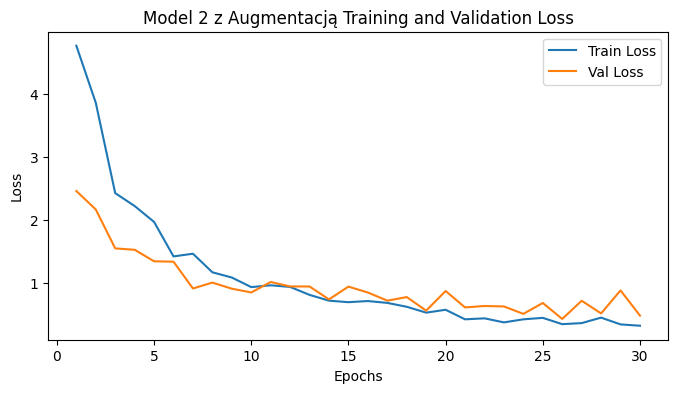

In [25]:
# training loop model 2 z augmentacją
model2_aug = CNN2(input_size=3, num_classes=len(class_names))
optimizer2_aug = torch.optim.Adam(model2_aug.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_losses_2_aug = []
val_losses_2_aug = []

for epoch in range(epochs):
    model2_aug.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader_aug):
        outputs = model2_aug(images)
        loss = criterion(outputs, labels)
    

        optimizer2_aug.zero_grad()
        loss.backward()
        optimizer2_aug.step()
        train_loss += loss.item()
    train_losses_2_aug.append(train_loss / len(train_loader_aug))

    model2_aug.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader_norm):
            outputs = model2_aug(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses_2_aug.append(val_loss / len(val_loader_norm))

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader_aug):.4f}, Val Loss: {val_loss/len(val_loader_norm):.4f}")

plt.figure(figsize=(8, 4))
plt.title("Model 2 z Augmentacją Training and Validation Loss")
plt.plot(range(1, epochs+1), train_losses_2_aug, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses_2_aug, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("figures/model2-aug-losses.png")
plt.show()

--- Ewaluacja dla: Model 2 (CNN2) z augmentacją ---

Raport klasyfikacji:
               precision    recall  f1-score   support

       anchor       1.00      1.00      1.00        11
      balloon       1.00      1.00      1.00         8
      bicycle       0.90      1.00      0.95         9
     envelope       1.00      0.88      0.93         8
   paper_boat       1.00      1.00      1.00         9
 peace_symbol       1.00      0.70      0.82        10
       smiley       0.58      1.00      0.74         7
speech_bubble       1.00      0.89      0.94         9
       spiral       1.00      0.75      0.86         8
        thumb       0.89      1.00      0.94         8

     accuracy                           0.92        87
    macro avg       0.94      0.92      0.92        87
 weighted avg       0.95      0.92      0.92        87



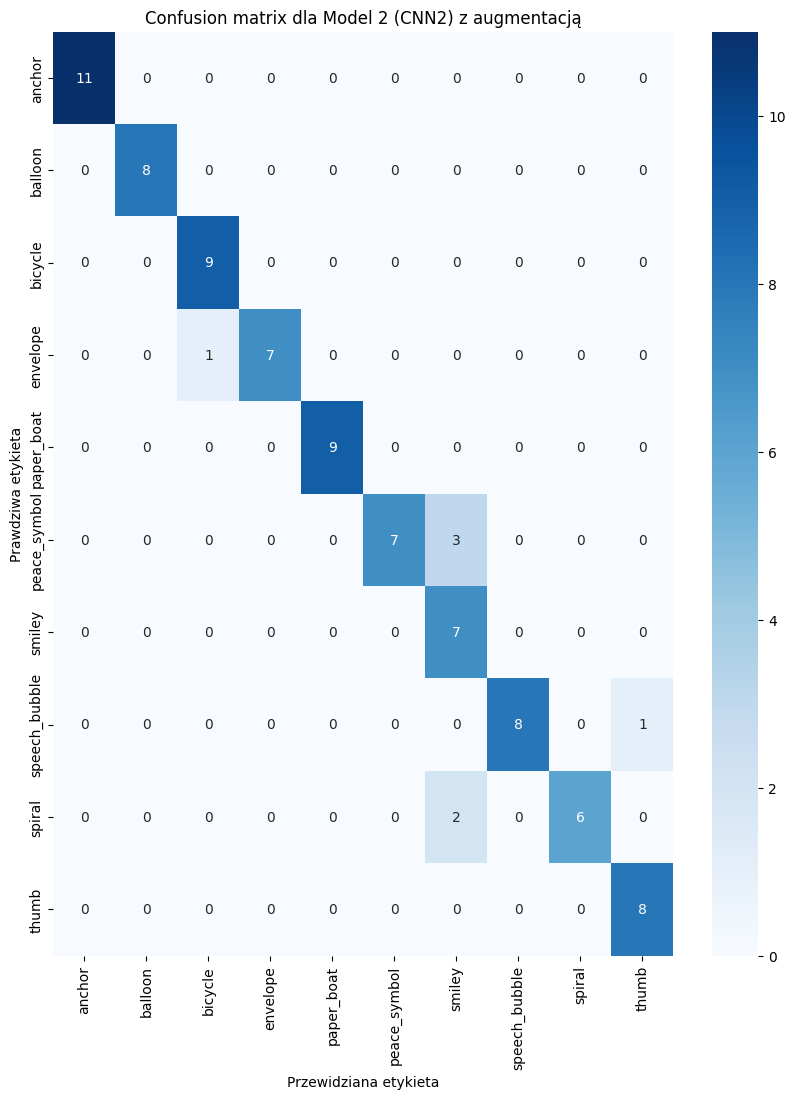

In [26]:
evaluate_model(model2_aug, test_loader_norm, "Model 2 (CNN2) z augmentacją")

Na podstawie przedstawionych wyników można wyciągnąć następujące wnioski:
* **Poprawa skuteczności:** Zastosowanie augmentacji danych przyniosło wyraźną poprawę we wszystkich kluczowych metrykach
* **Lepsza generalizacja:** Średni ważony F1-score podskoczył, co wskazuje, że model lepiej radzi sobie z klasyfikacją wszystkich kategorii, a nie tylko tych najłatwiejszych
* **Naprawa słabych punktów:** Augmentacja szczególnie pomogła w klasach, z którymi model miał największy problem, np. skuteczność dla klasy spiral oraz smiley wzrosła

To pokazuje, że augmentacja danych jest skuteczną techniką dla tego zbioru danych. Zwiększenie różnorodności obrazów treningowych pozwoliło modelowi lepiej generalizować na nowe dane.

### Activation maps (Grad-CAM)

Grad-CAM pozwala ona na stworzenie "mapy ciepła", która wizualizuje, które obszary na obrazie były dla modelu najważniejsze podczas klasyfikacji. Innymi słowy, możemy zobaczyć, na czym model "skupia swoją uwagę".

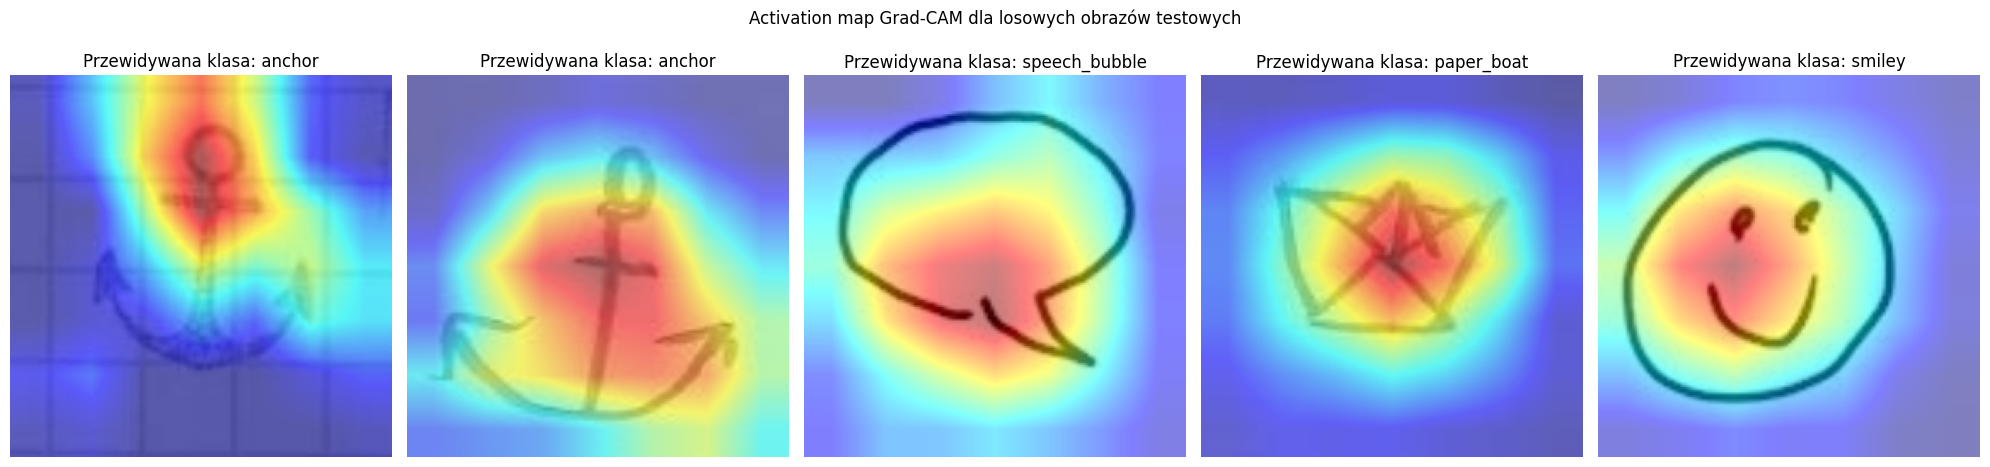

In [55]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

model_to_vis = model3
target_layer = [model_to_vis.layer4[-1].conv2]
n_img_to_show = 5

for param in model_to_vis.parameters():
    param.requires_grad = True

cam = GradCAM(model=model_to_vis, target_layers=target_layer)

fig, axes = plt.subplots(1, n_img_to_show, figsize=(20, 5))
fig.suptitle("Activation map Grad-CAM dla losowych obrazów testowych")

resize_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224)
])

ds = test_ds_pretrained
random_indices = np.random.choice(len(ds), n_img_to_show, replace=False)

for i, loc_idx in enumerate(random_indices):
    input_tensor, label_idx = ds[loc_idx]

    base = ds.dataset
    path, true_label = base.samples[ds.indices[loc_idx]]
    og_pil_img = Image.open(path).convert("RGB")

    input_tensor_batch = input_tensor.unsqueeze(0)

    targets = [ClassifierOutputTarget(label_idx)]
    grayscale_cam = cam(input_tensor=input_tensor_batch, targets=targets)[0]

    rgb_img_float = np.array(resize_transform(og_pil_img)) / 255.0
    vis = show_cam_on_image(rgb_img_float, grayscale_cam, use_rgb=True)
    
    model_to_vis.eval()
    with torch.no_grad():
        outputs = model_to_vis(input_tensor_batch)
        _, predicted = torch.max(outputs, 1)

    ax = axes[i]
    ax.imshow(vis)
    ax.set_title(f"Przewidywana klasa: {class_names[predicted.item()]}")
    ax.axis('off')

plt.tight_layout()
plt.savefig("figures/activation-maps.png")
plt.show()

Na podstawie wygenerowanych map aktywacji można wyciągnąć następujące wnioski:

* **Model nauczył się poprawnych cech:** Wizualizacje pokazują, że model w większości przypadków skupia swoją uwagę na charakterystycznych i istotnych częściach rysunku, a nie na tle czy przypadkowych elementach, np. dla klasy smiley aktywacja koncentruje się na oczach i uśmiechu
* **Potwierdzenie wysokiej skuteczności:** Taka interpretowalność daje nam pewność, że wysoka dokładność modelu nie jest dziełem przypadku, model nie nauczył się jakichś nieistotnych korelacji (np. koloru tła), ale faktycznie rozpoznaje kluczowe cechy obiektów na rysunkach
* **Potencjalne słabości:** W niektórych przypadkach (np. anchor) aktywacje są mniej precyzyjne i rozproszone. Może to sugerować, że cechy tych obiektów są mniej jednoznaczne, ale mimo to model był w stanie dokonać poprawnej klasyfikacji

In [56]:
torch.save(model3.state_dict(), 'resnet18.pth')